In [1]:
# import dependencies
import os
import numpy as np
import  pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNet, ResNet50
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import pathlib
import random
import warnings
from tensorflow.keras import backend as K
import tensorflow_hub as hub
warnings.filterwarnings("ignore")

W0621 14:09:09.201330 10836 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


In [2]:
# data directories
datadir = "../classification/"

In [3]:
os.listdir(datadir)

['fall army worm',
 'healthy',
 'herbicide burn',
 'magnesium deficiency',
 'maize streak',
 'multiple',
 'nitrogen deficiency',
 'potassium deficiency',
 'stalk borer',
 'sulphur deficiency',
 'zinc deficiency']

In [4]:
dataroot = pathlib.Path(datadir)
all_images = dataroot.glob("*/*")
all_images = [str(path) for path in all_images]

In [5]:
image_count = len(all_images)
image_count

866

In [6]:
img = plt.imread(random.choice(all_images))
img.shape

(300, 300, 3)

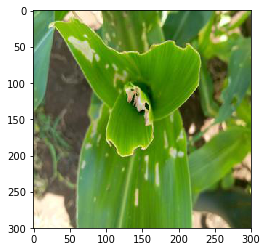

In [7]:
plt.imshow(img)

In [8]:
import IPython.display as display

def caption_image(image_path):
    image_rel = pathlib.Path(image_path).relative_to(datadir)
    return image_rel

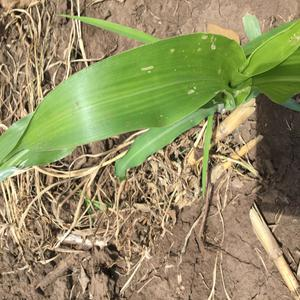

fall army worm\IMG_1123.JPG



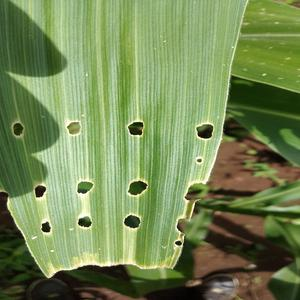

stalk borer\IMG20190523130147.jpg



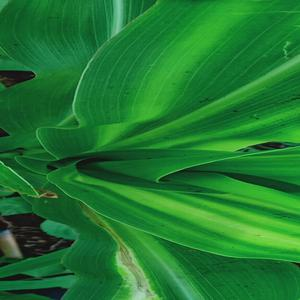

zinc deficiency\IMG20190523133206.jpg



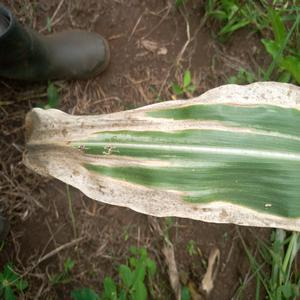

potassium deficiency\IMG_20190523_140519_2.jpg



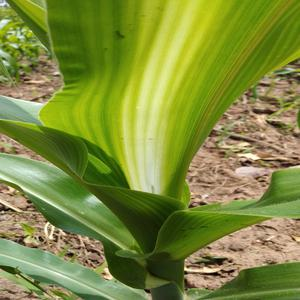

zinc deficiency\IMG20190523121147.jpg



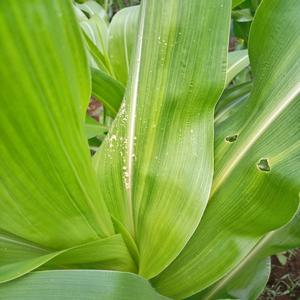

multiple\IMG_20190523_130053_4.jpg



In [9]:
for n in range(6):
    image_path = random.choice(all_images)
    display.display(display.Image(image_path))
    print(caption_image(image_path))
    print()

In [10]:
# loading images
datagen = ImageDataGenerator(horizontal_flip=True,rotation_range=0.5,rescale=1/255.0)

# Training with Hub keras

In [11]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/3" #@param {type:"string"}

In [12]:
def feature_extractor(x):
    feature_extractor_module = hub.Module(feature_extractor_url)
    return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

Instructions for updating:
Colocations handled automatically by placer.


W0621 14:09:10.356692 10836 deprecation.py:323] From C:\Users\Daniel\Anaconda3\lib\site-packages\tensorflow\python\ops\control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


In [13]:
IMAGE_SIZE

[224, 224]

In [14]:
image_data = datagen.flow_from_directory(datadir, target_size=IMAGE_SIZE)

Found 866 images belonging to 11 classes.


In [15]:
features_extractor_layer = tf.keras.layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])

In [16]:
features_extractor_layer.trainable = False

In [25]:
model = tf.keras.Sequential([
  features_extractor_layer,
  tf.keras.layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0621 14:49:42.120795 10836 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 11)                11022     
Total params: 11,022
Trainable params: 11,022
Non-trainable params: 0
_________________________________________________________________


In [26]:
sess = K.get_session()
init = tf.global_variables_initializer()

In [27]:
init = tf.global_variables_initializer()
sess.run(init)

In [28]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(), 
  loss='categorical_crossentropy',
  metrics=['accuracy'])

In [21]:
class CollectBatchStats(tf.keras.callbacks.Callback):
    def __init__(self):
        self.batch_losses = []
        self.batch_acc = []

    def on_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs['loss'])
        self.batch_acc.append(logs['acc'])

In [30]:
for image_batch, label_batch in image_data:
    print(label_batch.shape)
    break

(32, 11)


In [29]:
steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=9, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats], validation_split=0.20)

Epoch 1/9
27/27 [==============================] - 25s 916ms/step - loss: 1.8375 - acc: 0.5228
Epoch 2/9
27/27 [==============================] - 23s 867ms/step - loss: 0.7318 - acc: 0.7710
Epoch 3/9
27/27 [==============================] - 24s 902ms/step - loss: 0.5199 - acc: 0.8241
Epoch 4/9
27/27 [==============================] - 24s 871ms/step - loss: 0.4130 - acc: 0.8573
Epoch 5/9
27/27 [==============================] - 23s 862ms/step - loss: 0.3508 - acc: 0.8837
Epoch 6/9
27/27 [==============================] - 23s 860ms/step - loss: 0.2590 - acc: 0.9137
Epoch 7/9
27/27 [==============================] - 23s 857ms/step - loss: 0.2792 - acc: 0.9113
Epoch 8/9
27/27 [==============================] - 23s 866ms/step - loss: 0.2378 - acc: 0.9209
Epoch 9/9
27/27 [==============================] - 23s 856ms/step - loss: 0.2613 - acc: 0.9137


In [40]:
model.save("maize_image_model.h5")

In [33]:
image_data.class_indices

{'fall army worm': 0,
 'healthy': 1,
 'herbicide burn': 2,
 'magnesium deficiency': 3,
 'maize streak': 4,
 'multiple': 5,
 'nitrogen deficiency': 6,
 'potassium deficiency': 7,
 'stalk borer': 8,
 'sulphur deficiency': 9,
 'zinc deficiency': 10}

In [107]:
image_paths = all_images[860:870]

In [108]:
image_paths

['..\\classification\\zinc deficiency\\IMG_20190523_133529_3.jpg',
 '..\\classification\\zinc deficiency\\IMG_20190523_133530_2.jpg',
 '..\\classification\\zinc deficiency\\IMG_20190523_135627_6.jpg',
 '..\\classification\\zinc deficiency\\IMG_20190523_140051_0.jpg',
 '..\\classification\\zinc deficiency\\IMG_20190523_140051_7.jpg',
 '..\\classification\\zinc deficiency\\IMG_20190523_142108_8.jpg']

In [109]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [110]:
images = []

In [111]:
for file in image_paths:
    image = load_img(file)
    image = img_to_array(image)
    images.append(image)

In [112]:
new_images = []

In [113]:
for img in images:
    new = np.resize(img,(224,224,3) )
    new_images.append(new)

In [114]:
new_images[0].shape

(224, 224, 3)

In [115]:
new_images = np.array(new_images)

In [116]:
predictions = model.predict_classes(new_images)

In [117]:
predictions[5]

4